In [1]:
import os
import re

import pandas as pd
import numpy as np
import unicodedata
import matplotlib.pyplot as plt

import collections
import wordcloud as wc

import nltk

from sklearn.feature_extraction.text import CountVectorizer

### Dataset initial

In [3]:
input_path = "data/cdiscount_train.csv.zip"
nb_line=100000
data_all = pd.read_csv(input_path, sep=",", nrows=nb_line)
data_all = data_all.fillna("") # pour les valeurs nulles
data_all.head()

,Categorie1,Categorie2,Categorie3,Description,Libelle,Marque
0,INFORMATIQUE,CONNECTIQUE - ALIMENTATION,BATTERIE,Batterie Acer Aspire One 751H-52Yr - Li-Ion 11...,Batterie Acer Aspire One 751H-52Yr,AUCUNE
1,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE - BUMPER - FACADE TELEPHONE,Coque rigide Bleu lagon pour ALCATEL OT / 6033...,Coque rigide Bleu lagon pour ALCATEL OT / 6033 …,MUZZANO
2,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE - BUMPER - FACADE TELEPHONE,Facades et coques CELLULAR LINE SHCKGALS 3 MIN...,Facades et coques CELLULAR LINE SHCKGALS 3 MINIP,CELLULAR LINE
3,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE - BUMPER - FACADE TELEPHONE,Coque meteore TPU LG Nexus 4 / E960,Coque meteore TPU LG Nexus 4 / E960,AUCUNE
4,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE - BUMPER - FACADE TELEPHONE,Coque souple Transparente pour LG G FLEX D959 ...,Coque souple Transparente pour LG G FLEX D959 m…,MUZZANO


## Dataset utilisé

In [4]:
data = data_all[["Categorie1","Description"]]
print(type(data))
print(data.shape)

<class 'pandas.core.frame.DataFrame'>
(100000, 2)


In [5]:
data.head()

,Categorie1,Description
0,INFORMATIQUE,Batterie Acer Aspire One 751H-52Yr - Li-Ion 11...
1,TELEPHONIE - GPS,Coque rigide Bleu lagon pour ALCATEL OT / 6033...
2,TELEPHONIE - GPS,Facades et coques CELLULAR LINE SHCKGALS 3 MIN...
3,TELEPHONIE - GPS,Coque meteore TPU LG Nexus 4 / E960
4,TELEPHONIE - GPS,Coque souple Transparente pour LG G FLEX D959 ...


## Stats descriptives

In [6]:
data.describe(include='all')

,Categorie1,Description
count,100000,100000
unique,44,96591
top,TELEPHONIE - GPS,4400mAh | 10.8V | Li-ion - 4400mAh | 10.8V | L...
freq,21325,97


#### Comments :

- Categorie avec le + de produits : Telephonie-GPS
- 44 catégories au total
- 100000 produits
- 3500 decriptions sont identiques

In [136]:
data['Categorie1'].value_counts()
cat_list=data['Categorie1'].value_counts().index.tolist()

In [137]:
data[data['Categorie1']=="PRODUITS FRAIS"] #recup une ligne spécifique

,Categorie1,Description
52370,PRODUITS FRAIS,NATINE - Mes tartines au millet - SANS SEL - B...
65640,PRODUITS FRAIS,Pain au chocolat - PASQUIER - Pain au chocolat...
84471,PRODUITS FRAIS,"Riz cantonais - Riz cuit 57,4% (riz - eau - br..."
89657,PRODUITS FRAIS,Yaourt brassé nature - VELOUTE - Yaourt brassé...


In [138]:
freq = data.groupby("Categorie1")
freq

In [139]:
nb = freq.count()
freq_cat = nb.sort_values("Description", ascending=False)
freq_cat.head()

,Description
Categorie1,
TELEPHONIE - GPS,21325
INFORMATIQUE,14597
LIBRAIRIE,12121
VETEMENTS - LINGERIE,6023
BIJOUX - LUNETTES - MONTRES,6014


<Figure size 432x288 with 0 Axes>

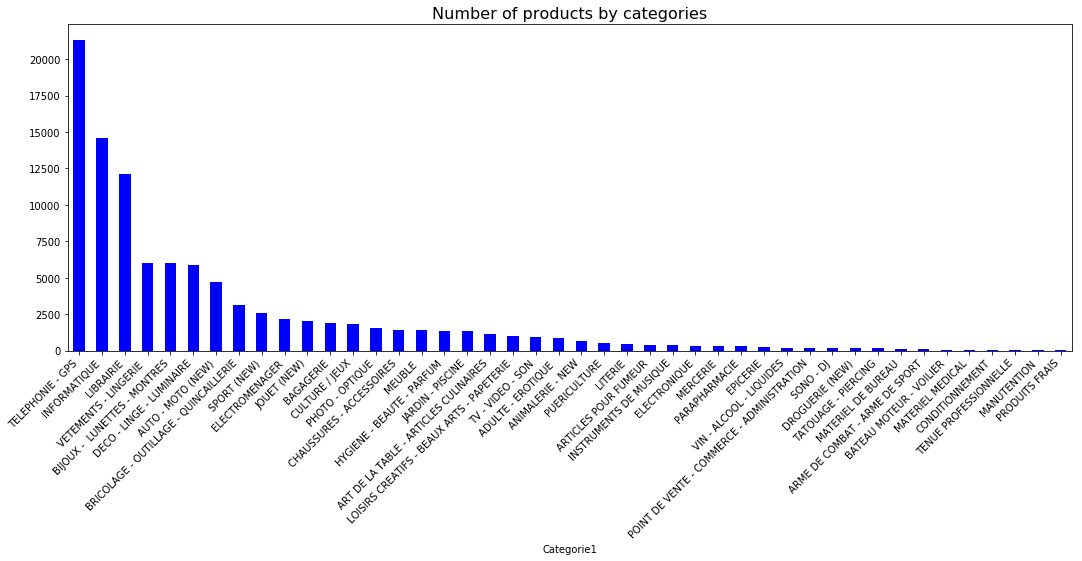

In [142]:


fig=plt.figure()
ax =freq_cat.plot(kind = "bar", figsize=(18,6), color='b')
ax.set_xticklabels(cat_list, rotation=45, ha='right')
#ax.set_xlabel("Categories", fontsize=16)
plt.title("Number of products by categories", fontsize=16)
ax.legend().set_visible(False)  # supprime la légende


In [143]:
print((data['Categorie1']=="LIBRAIRIE").value_counts())

False    87879
True     12121
Name: Categorie1, dtype: int64


## Création d'un dataframe du vocab / catégorie

In [150]:
cat = data['Categorie1'].unique().tolist() #liste des categories 
print(cat_list)

['TELEPHONIE - GPS', 'INFORMATIQUE', 'LIBRAIRIE', 'VETEMENTS - LINGERIE ', 'BIJOUX -  LUNETTES - MONTRES', 'DECO - LINGE - LUMINAIRE', 'AUTO - MOTO (NEW)', 'BRICOLAGE - OUTILLAGE - QUINCAILLERIE', 'SPORT (NEW)', 'ELECTROMENAGER', 'JOUET (NEW)', 'BAGAGERIE', 'CULTURE / JEUX', 'PHOTO - OPTIQUE', 'CHAUSSURES - ACCESSOIRES', 'MEUBLE ', 'HYGIENE - BEAUTE - PARFUM', 'JARDIN - PISCINE', 'ART DE LA TABLE - ARTICLES CULINAIRES', 'LOISIRS CREATIFS - BEAUX ARTS - PAPETERIE', 'TV - VIDEO - SON', 'ADULTE - EROTIQUE ', 'ANIMALERIE - NEW', 'PUERICULTURE', 'LITERIE', 'ARTICLES POUR FUMEUR', 'INSTRUMENTS DE MUSIQUE', 'ELECTRONIQUE', 'MERCERIE', 'PARAPHARMACIE', 'EPICERIE', 'VIN - ALCOOL - LIQUIDES', 'POINT DE VENTE - COMMERCE - ADMINISTRATION', 'SONO - DJ', 'DROGUERIE (NEW)', 'TATOUAGE - PIERCING', 'MATERIEL DE BUREAU', 'ARME DE COMBAT - ARME DE SPORT', 'BATEAU MOTEUR - VOILIER', 'MATERIEL MEDICAL', 'CONDITIONNEMENT', 'TENUE PROFESSIONNELLE', 'MANUTENTION', 'PRODUITS FRAIS']


In [202]:
## Creation d'un data frame par categories
new = []
for i in cat_list :    
    voca = ""    
    c = data[data['Categorie1']==i].index #selectionne les lignes correspondantes a la categorie
    for index in c :
        voca += data['Description'][index]
        voca += " "
    new.append([i,voca]) #nom categorie + voca associé

df = pd.DataFrame(new,columns=['Categorie','Description'])
df.head()

,Categorie,Description
0,TELEPHONIE - GPS,Coque rigide Bleu lagon pour ALCATEL OT / 6033...
1,INFORMATIQUE,Batterie Acer Aspire One 751H-52Yr - Li-Ion 11...
2,LIBRAIRIE,De Teo aux éditions EMMANUEL PROUST Saint Seiy...
3,VETEMENTS - LINGERIE,debardeur femme superman or - … Voir la présen...
4,BIJOUX - LUNETTES - MONTRES,Seiko SFP599 Hommes Montre - Acheter Authentiq...


In [155]:
i_frai = df[df['Categorie']=="PRODUITS FRAIS"].index 
frai = df['Description'][i_frai[0]] #recup vocabulaire de categorie produits frais
#print(frai.split(" "))
print("total : ", len(frai.split(" "))) #compte nb de mots
print("unique : ", len(set(frai.split(" ")))) #compte nb mots uniques

total :  102
unique :  58


In [156]:
# Verification avec les données initiales
index_frai = data[data['Categorie1']=="PRODUITS FRAIS"].index 
for i in index_frai :
    b = data['Description'][index_frai]
    
print(b)

52370    NATINE - Mes tartines au millet - SANS SEL - B...
65640    Pain au chocolat - PASQUIER - Pain au chocolat...
84471    Riz cantonais - Riz cuit 57,4% (riz - eau - br...
89657    Yaourt brassé nature - VELOUTE - Yaourt brassé...
Name: Description, dtype: object


### Afficher nb de mots unique par categorie

In [203]:
nb = []
uniq = []

for cat_i in range(44) :
    voc_cat_i = df['Description'][cat_i]
    nb.append(len(voc_cat_i.split(" ")))
    uniq.append(len(set(voc_cat_i.split(" "))))

In [206]:
df['Total words'] = nb
df['Uniq words'] = uniq
data_voc = df.sort_values(by = 'Total words', ascending=False)
data_voc

,Categorie,Description,Total words,Uniq words
0,TELEPHONIE - GPS,Coque rigide Bleu lagon pour ALCATEL OT / 6033...,666273,24823
1,INFORMATIQUE,Batterie Acer Aspire One 751H-52Yr - Li-Ion 11...,350279,34009
5,DECO - LINGE - LUMINAIRE,"Cars Poster Reproduction Sur Toile, Tendue Sur...",173110,22908
3,VETEMENTS - LINGERIE,debardeur femme superman or - … Voir la présen...,155486,22869
4,BIJOUX - LUNETTES - MONTRES,Seiko SFP599 Hommes Montre - Acheter Authentiq...,151162,19582
6,AUTO - MOTO (NEW),Tube de fourche Tarozzi KYMCO X-CITING 500 - 0...,130557,18455
2,LIBRAIRIE,De Teo aux éditions EMMANUEL PROUST Saint Seiy...,104108,22468
7,BRICOLAGE - OUTILLAGE - QUINCAILLERIE,Clé polygonale double contre-coudée - 20x22 - ...,81829,18792
8,SPORT (NEW),Huile Rock Shox Deo Brunox pour fourreaux de f...,69917,16815
11,BAGAGERIE,portefeuille porte cartes billets compagnon fe...,55178,9791


In [199]:
print(u'\u2026')
print(u'\u00a0')
print(u'\u005F')

…
 
_


In [209]:
main_cat = data_voc['Categorie'][0:7].tolist() #recup valeurs d'une colonne
main_tot = data_voc['Total words'][0:7].tolist()
main_uniq = data_voc['Uniq words'][0:7].tolist()

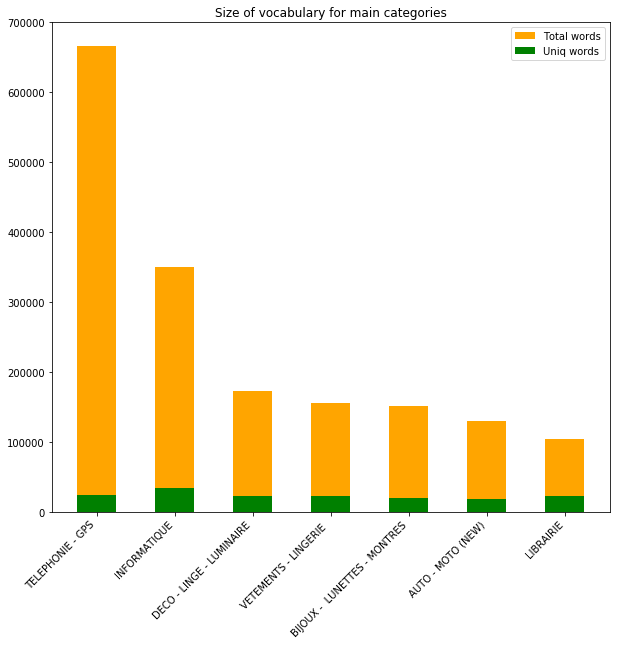

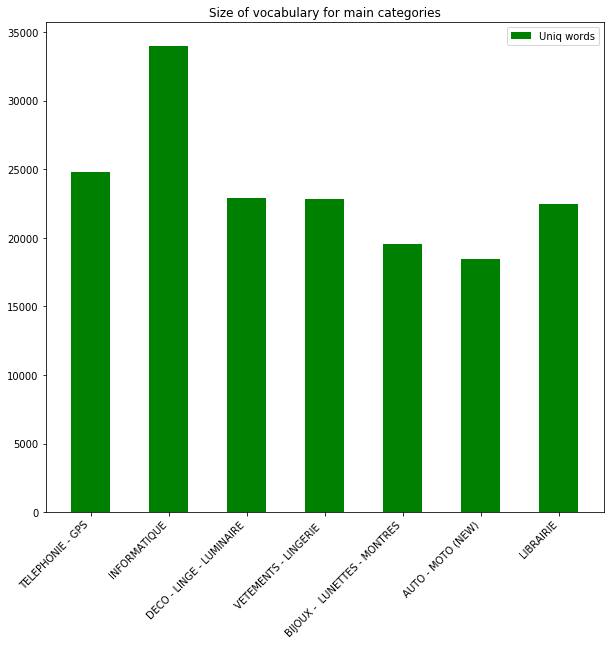

In [224]:
fig = plt.figure(figsize=(10,10))
plt.bar(main_cat,main_tot,width = 0.5, color = 'orange', label="Total words")
plt.bar(main_cat,main_uniq,width = 0.5, color = 'green', label="Uniq words")
plt.title("Size of vocabulary for main categories")
plt.legend()
fig.autofmt_xdate(rotation=45)


fig = plt.figure(figsize=(10,10))
plt.bar(main_cat,main_uniq,width = 0.5, color = 'green', label="Uniq words")
plt.title("Size of vocabulary for main categories")
plt.legend()
fig.autofmt_xdate(rotation=45)

## Cleaning

In [225]:
nltk.download("stopwords") #chargement des stop words

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/paulbrunet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Clean sur un string

In [226]:
#vocabulaire TOTAL, toutes catégories confondues

voca = "" 
for k in range(nb_line):
    des = data['Description'][k]
    voca += " "
    voca += des

In [249]:
def cleaning(voca) :
    print("Cleaning function :")
    print("Total words :" ,len(voca.split(" ")))
    print("Unique words :" ,len(set(voca.split(" "))))
    print("Ratio words :" , len(voca.split(" "))/len(set(voca.split(" "))), "\n \n")

    
    #STEP 1 : Standardization
    cleaned_voc = voca
    cleaned_voc = cleaned_voc.lower()
    cleaned_voc = cleaned_voc.replace(u'\u2026','.') #put the vocabulary in lower
    cleaned_voc = cleaned_voc.replace(u'\u00a0',' ') #removing special character 
    cleaned_voc = cleaned_voc.replace(u'\u005F',' ')
    cleaned_voc = unicodedata.normalize('NFD', cleaned_voc).encode('ascii', 'ignore').decode("utf-8") #takes off some punctuation
    cleaned_voc = re.sub('[^a-z_]', ' ', cleaned_voc) # keeps only alphabet letters
    print("Total after step 1 :", len(cleaned_voc.split(" ")))
    print("Uniq after step 1 :", len(set(cleaned_voc.split(" "))) , "\n \n")

    
    #STEP 2 : Removing french stopwords using NLTK
    stopwords = nltk.corpus.stopwords.words('french') 
    stopwords = [unicodedata.normalize('NFD', sw).encode('ascii', 'ignore').decode("utf-8") for sw in stopwords]
    stopwords += ["voir"]
    stopwords += ["presentation"]
    
    stopwordsenglish = nltk.corpus.stopwords.words('english')
    stopwordsenglish = [unicodedata.normalize('NFD', sw).encode('ascii', 'ignore').decode("utf-8") for sw in stopwordsenglish]
   
    
    tokens = [w for w in cleaned_voc.split(" ") if (len(w)>2) and (w not in stopwords) and (w not in stopwordsenglish)]
    removed_words = [w for w in cleaned_voc.split(" ") if (len(w)<2) or (w in stopwords) or (w in stopwordsenglish)]
    print("Total after step 2 :", len(tokens))
    print("Uniq after step 2 :", len(set(tokens)) , "\n \n")
    
    #STEP 3 : Stemming
    stemmer=nltk.stem.SnowballStemmer('french')
    stemmer2=nltk.stem.SnowballStemmer('english')
    tokens_stem = [stemmer2.stem(token) for token in tokens]
    tokens_stem = [stemmer.stem(token) for token in tokens]
    
    print("Total tokens after step 3 :" , len(tokens_stem))
    print("Unique tokens after step 3 :" ,len(set(tokens_stem)))
    print("Ratio tokens :" , len(tokens_stem)/len(set(tokens_stem)))
    
    return tokens_stem

In [250]:
cleaned_voc = cleaning(voca)

Cleaning function :
Total words : 2514812
Unique words : 219119
Ratio words : 11.47692349819048 
 

Total after step 1 : 3794485
Uniq after step 1 : 75361 
 

Total after step 2 : 1368185
Uniq after step 2 : 74498 
 

Total tokens after step 3 : 1368185
Unique tokens after step 3 : 57871
Ratio tokens : 23.641979575262223


In [245]:
row_sum = df.sum() 

print("Nb of total words : ", row_sum[2]) 

# ICI PROBLEME : unique 357 853, ça correspond pas à 219 119 ????
# mots dans plusieurs catégories 

# Le delta est du au caractère '_'

Nb of total words :  2514855


### Clean à partir d'un dataframe

In [25]:
a = df['Description'][0] #recup la description d'une cat

In [26]:
# a la fin j'ai pas encore trouvé comment modifier la description du dataset et mettre celle nettoyé à la place
# Je voulais comparé les résultats avec la fonction précédente voir ce qu'il en est au niveau du comptage de mots


def cleaning_df(df) :

    row_sum = df.sum() 
    print("Total words :" , row_sum[2])
    print("Unique words :" ,row_sum[3], "\n \n")
    
    for i in range(44) : 
        voca = df['Description'][i]
        #STEP 1 : Standardization
        cleaned_voc = voca
        cleaned_voc = cleaned_voc.lower()
        cleaned_voc = cleaned_voc.replace(u'\u2026','.') #put the vocabulary in lower
        cleaned_voc = cleaned_voc.replace(u'\u00a0',' ') #removing special character 
        cleaned_voc = unicodedata.normalize('NFD', cleaned_voc).encode('ascii', 'ignore').decode("utf-8") #takes off some punctuation
        cleaned_voc = re.sub('[^a-z_]', ' ', cleaned_voc) # keeps only alphabet letters


        #STEP 2 : Removing french stopwords using NLTK
        stopwords = nltk.corpus.stopwords.words('french') 
        stopwords = [unicodedata.normalize('NFD', sw).encode('ascii', 'ignore').decode("utf-8") for sw in stopwords]
        stopwords += ["voir"]
        stopwords += ["presentation"]

        tokens = [w for w in cleaned_voc.split(" ") if (len(w)>2) and (w not in stopwords)]
        removed_words = [w for w in cleaned_voc.split(" ") if (len(w)<2) or (w in stopwords)]


        #STEP 3 : Stemming
        stemmer=nltk.stem.SnowballStemmer('french')
        tokens_stem = [stemmer.stem(token) for token in tokens]
        
        # df['Description'][i] = tokens_stem
        
    return df

In [27]:
df_cleaned = cleaning_df(df)

Total words : 2514855
Unique words : 357853 
 



<ipython-input-26-9fc2b5689720>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Description'][i] = tokens_stem
